# Detekcja krawędzi

## Cel ćwiczenia

- Zapoznanie z metodami detekcji krawędzi:
    - Sobel, Prewitt, Roberts - przypomnienie,
    - Laplasjan z Gaussa (LoG – ang. Laplacian of Gaussian),
    - Canny.

Detekcja krawędzi przez wiele lat była podstawą algorytmów segmentacji.
Krawędzie wykrywane są najczęściej z wykorzystaniem pierwszej (gradient) i drugiej (Laplasjan) pochodnej przestrzennej.
Wykorzystanie obu metod zaprezentowane zostało w ćwiczeniu *Przetwarzanie wstępne. Filtracja kontekstowa*.

W niniejszym ćwiczeniu poznane detektory krawędzi zostaną porównane z bardziej zaawansowanymi: Laplasjan z funkcji Gaussa (LoG), Zero Crossing i Canny.

## Laplasjan z Gaussa (LoG)

Funkcja Gaussa:<br>
\begin{equation}
h(r) = e^{\frac{-r^2}{2 \sigma^2}}
\end{equation}<br>
gdzie:
- $r^2 = x^2 + y^2$
- $\sigma$ to odchylenie standardowe.

Działanie filtracji Gaussowskiej zostało przedstawione w ćwiczeniu "Przetwarzanie wstępne". W jej wyniku następuje rozmazanie obrazu.
Laplasjan tej funkcji dany jest wzorem:

\begin{equation}
\nabla^2 h(r) = \frac{r^2 - 2\sigma^2}{\sigma^4} e^{-\frac{r^2}{2\sigma^2}}
\end{equation}

Funkcję (z oczywistych powodów) nazywamy Laplasjan z Gaussa (LoG).
Ponieważ druga pochodna jest operacją liniową, konwolucja obrazu z $\nabla^2 h(r)$ daje taki sam efekt jak zastosowanie filtracji Gaussa na obrazie, a następnie obliczenie Laplasjanu z wyniku.
Lokalizacja krawędzi polega na znalezieniu miejsca, gdzie po filtracji LoG następuje zmiana znaku.

1. Wczytaj obraz *house.png*.
2. Wykonaj rozmycie Gaussowskie obrazu wejściowego.
W tym celu wykorzysaj funkcję `cv2.GaussianBlur(img, kSize, sigma)`.
Pierwszy argument jest obrazem wejśćiowym.
Drugi jest rozmiarem filtru (podanym w nawiasach okrągłych, np. *(3, 3)*).
Trzecim argumentem jest odchylenie standardowe. Wartość jest dobrana automatycznie, jeśli zosanie podana wartość `0` (będą równe rozmiarowi).
3. Oblicz laplasjan obrazu rozmytego.
W tym celu wykorzysaj funkcję `cv2.Laplacian(img, ddepth)`.
Pierszym argumentem jest obraz wejściowy.
Drugim argumentem jest typ danych wejściowych. Użyj `cv2.CV_32F`.
4. Wyznacz miejsca zmiany znaku.
Zaimplementuj funkcję `crossing(LoG, thr)`:
    - Najpierw stwórz tablicę, do której zostanie zapisany wynik.
    Jej rozmiar jest taki sam jak przetwarzanego obrazu.
    - Następnie wykonaj pętle po obrazie (bez ramki jednopikselowej).
    W każdej iteracji stwórz otoczenie o rozmiarze $3 \times 3$.
    Dla otoczenia oblicz wartość maksymalną i minimalną.
    - Jeśli wartości te mają przeciwne znaki, to do danego miejsca tablicy przypisz wartość:
        - jeśli piksel wejściowy > 0, to dodaj do niego wartość bezwzględną minimum.
        - jeśli piksel wejściowy < 0, to do jego wartości bezwzględnej dodaj maksimum.
    - Zmień zakres wykonanej tablicy do $<0, 255>$.
    - Wykonaj progowanie tablicy. Próg jest argumentem wejściowym.
    - Przeskaluj dane binarne do wartości `[0, 255]`.
    - Wykonaj konwersję do typu *uint8*.
    - Wykonaj rozmycie medianowe wyniku.
    Wykorzystaj funkcję `cv2.medianBlur(img, kSize)`.
    Pierwszym argumentem jest obraz wejśćiowy, a drugim rozmiar filtra.
    - Zwróć wyznaczoną tablicę.
5. Wyświetl obraz wynikowy.
6. Dobierz parametry (rozmiar filtru Gaussa, odchylenie standardowe, próg binaryzacji) tak, by widoczne były kontury domu, ale nie dachówki.

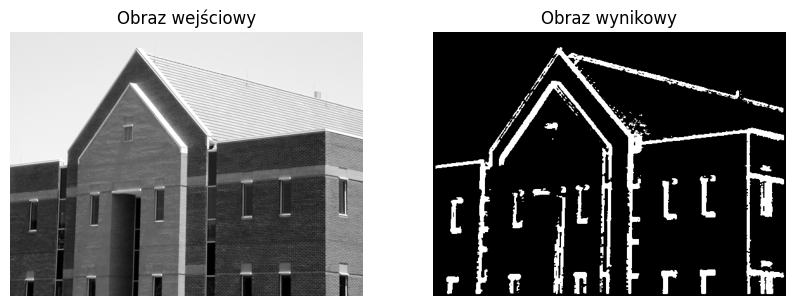

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import os

if not os.path.exists("dom.png") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/09_Canny/dom.png --no-check-certificate

house = cv2.imread('dom.png',cv2.IMREAD_GRAYSCALE)

def crossing(LoG,thr,size):
    result_image = np.zeros(LoG.shape)
    for i in range(size//2,LoG.shape[0]-size//2):
        for j in range(size//2,LoG.shape[1]-size//2):
            surr = LoG[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
            min_val = np.min(surr)
            max_val = np.max(surr)
            if np.sign(min_val) != np.sign(max_val):
                if LoG[i,j] > 0:
                    result_image[i,j] += LoG[i,j] + abs(min_val)
                elif LoG[i,j] < 0:
                    result_image[i,j] += abs(LoG[i,j]) + max_val
    result_image = result_image/np.max(result_image) * 255
    result_image = (result_image >= thr) * 255
    result_image = result_image.astype('uint8')
    result_image_median = cv2.medianBlur(result_image,size//2)
    return result_image_median 

def detect_edge(image,size,sigma,thr):
    image_result = cv2.GaussianBlur(image,(size,size),sigma)
    image_result = cv2.Laplacian(image_result,cv2.CV_32F)
    image_result = crossing(image_result,thr,size)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(image,'gray')
    plt.title('Obraz wejściowy')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(image_result,'gray')
    plt.title('Obraz wynikowy')
    plt.axis('off')
    plt.show()    

detect_edge(house,7,1.4,53)

## Algorytm Canny'ego

> Algorytm Canny'ego to często wykorzystywana metoda detekcji krawędzi.
> Zaproponowana została w~1986r. przez Johna F. Cannego.
> Przy jego projektowaniu założono trzy cele:
> - niska liczba błędów - algorytm powinien znajdywać wszystkie krawędzie oraz generować jak najmniej fałszywych detekcji,
> - punkty krawędziowe powinny być poprawnie lokalizowane - wykryte punkty powinny być jak najbardziej zbliżone do rzeczywistych,
> - krawędzie o szerokości 1 piksela - algorytm powinien zwrócić jeden punkt dla każdej rzeczywistej krawędzi.

Zaimplementuj pierwszą część algorytmu detekcji krawędzi Canny'ego:
1. W pierwszym kroku obraz przefiltruj dwuwymiarowym filtrem Gaussa.
2. Następnie oblicz gradient pionowy i poziomy ($g_x $ i $g_y$).
Jedną z metod jest filtracja Sobela.
3. Dalej oblicz amplitudę:
$M(x,y)  = \sqrt{g_x^2+g_y^2}$ oraz kąt:
$\alpha(x,y) = arctan(\frac{g_y}{g_x})$.
Do obliczenia kąta wykorzystaj funkcję `np.arctan2(x1, x2)`.
Wynik jest w radianach.
4. W kolejnym etapie wykonaj kwantyzację kątów gradientu.
Kąty od $-180^\circ$ do $180^\circ$ można podzielić na 8 przedziałów:
[$-22.5^\circ, 22.5^\circ$], [$22.5^\circ, 67.5^\circ$],
[$67.5^\circ, 112.5^\circ$], [$112.5^\circ, 157.5^\circ$],
[$157.5^\circ, -157.5^\circ$], [$-157.5^\circ, -112.5^\circ$],
[$-112.5^\circ, -67.5^\circ$], [$-67.5^\circ, -22.5^\circ$].
Przy czym należy rozpatrywać tylko 4 kierunki:
    - pionowy ($d_1$),
    - poziomy ($d_2$),
    - skośny lewy ($d_3$),
    - skośny prawy ($d_4$).
5. Dalej przeprowadź eliminację pikseli, które nie mają wartości maksymalnej (ang. *nonmaximal suppresion*).
Celem tej operacji jest redukcja szerokości krawędzi do rozmiaru 1 piksela.
Algorytm przebiega następująco.
W rozpatrywanym otoczeniu o rozmiarze $3 \times 3$:
    - określ do którego przedziału należy kierunek gradientu piksela centralnego ($d_1, d_2, d_3, d_4$).
    - przeanalizuje sąsiadów leżących na tym kierunku.
Jeśli choć jeden z nich ma amplitudę większą niż piksel centralny, to należy uznać, że nie jest lokalnym maksimum i do wyniku przypisać $g_N(x,y) = 0$.
W przeciwnym przypadku $g_N(x,y) = M(x,y)$.
Przez $g_N$ rozumiemy obraz detekcji lokalnych maksimów.
Zaimplementuj funkcję `nonmax`.
Pierwszym argementem jest macierz kierunków (po kwantyzacji).
Drugim argumentem jest macierz amplitudy.
6. Ostatnią operacją jest binaryzacja obrazu $g_N$.
Stosuje się tutaj tzw. binaryzację z histerezą.
Wykorzystuje się w niej dwa progi: $T_L$ i $T_H$, przy czym $T_L < T_H$.
Canny zaproponował, aby stosunek progu wyższego do niższego był jak 3 lub 2 do 1.
Rezultaty binaryzacji można opisać jako:<br>
$g_{NH}(x,y) = g_N(x,y) \geq TH $<br>
$g_{NL}(x,y) = TH > g_N(x,y) \geq TL $<br>
Można powiedzieć, że na obrazie $g_{NH}$ są "pewne" krawędzie.
Natomiast na $g_{NL}$ "potencjalne".
7. Na jednym obrazie zaznacz piksele należące do obrazu $g_{NH}$ jako czerwone oraz należące do obrazu $g_{NL}$ jako niebieskie.
Wyświetl obraz.

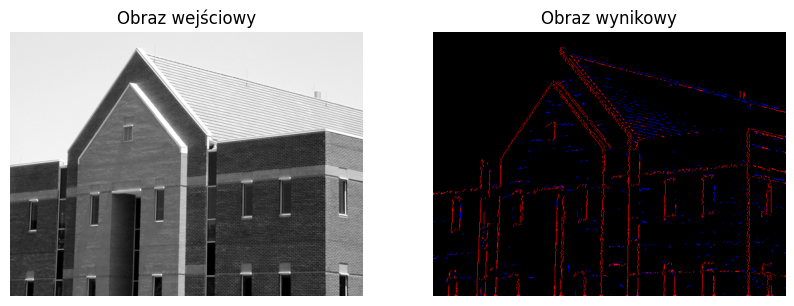

In [7]:
def fgaussian(size, sigma):
     m = n = size
     h, k = m//2, n//2
     x, y = np.mgrid[-h:h+1, -k:k+1]
     g = np.exp(-(x**2 + y**2)/(2*sigma**2))
     return g /g.sum() 

def nonmax(a,M,size):
     result = np.copy(M)
     for i in range(size//2,M.shape[0]-size//2):
          for j in range(size//2,M.shape[1]-size//2):
               surr = M[i-size//2:i+size//2+1,j-size//2:j+size//2+1]
               if a[i,j] == 1:
                    for i_surr in range(-size//2,size//2+1):
                         if M[i+i_surr,j] > M[i,j]:
                              result[i,j] = 0
               if a[i,j] == 2:
                  for j_surr in range(-size//2,size//2+1):
                       if M[i,j+j_surr] > M[i,j]:
                            result[i,j] = 0
               if a[i,j] == 3:
                  for i_j_surr in range(-size//2,size//2+1):
                       if M[i+i_j_surr,j+i_j_surr] > M[i,j]:
                            result[i,j] = 0
               if a[i,j] == 4:
                  for i_j_surr in range(-size//2,size//2+1):
                       if M[i-i_j_surr,j+i_j_surr] > M[i,j]:
                            result[i,j] = 0
     return result

def canny(image,size,sigma,Tl,Th):
     f_gauss = fgaussian(size,sigma)
     S1=np.array([[-1,0,1],[-2,0,2],[-1,0,1]])/8
     S2=np.array([[-1,-2,-1],[0,0,0],[1,2,1]])/8
     image_filter = cv2.filter2D(image,-1,f_gauss)
     image_x = cv2.filter2D(image_filter,-1,S1)
     image_y = cv2.filter2D(image_filter,-1,S2)
     M = np.sqrt(image_x*image_x+image_y*image_y)
     alpha = np.arctan2(image_y,image_x) * 180/np.pi
     for i in range(alpha.shape[0]):
          for j in range(alpha.shape[1]):
               if -22.5<=alpha[i,j]<=22.5 or -157.5<=alpha[i,j]<=157.5:
                    alpha[i,j] = 2
               elif 22.5<=alpha[i,j]<=67.5 or -157.5<=alpha[i,j]<=-112.5:
                    alpha[i,j] = 4
               elif 67.5<=alpha[i,j]<=112.5 or -112.5<=alpha[i,j]<=-67.5:
                    alpha[i,j] = 1
               elif 112.5<=alpha[i,j]<=157.5 or -67.5<=alpha[i,j]<=-22.5:
                    alpha[i,j] = 3
     nonm = nonmax(alpha,M,size)
     result = np.zeros((image.shape[0],image.shape[1],3))
     for i in range(nonm.shape[0]):
          for j in range(nonm.shape[1]):
               if nonm[i,j] >= Th:
                    result[i,j,0] = 255
               elif Tl<=nonm[i,j]<Th:
                    result[i,j,2] = 255
     result = result.astype('uint8')
     
     plt.figure(figsize=(10,10))
     plt.subplot(1,2,1)
     plt.imshow(image,'gray')
     plt.title('Obraz wejściowy')
     plt.axis('off')
     plt.subplot(1,2,2)
     plt.imshow(result)
     plt.title('Obraz wynikowy')
     plt.axis('off')
     plt.show() 

canny(house,5,1.5,4,6)


## Algorytm Canny'ego - OpenCV

1. Wykonaj dektekcję krawędzi metodą Canny'ego wykorzystując funkcję `cv2.Canny`.
    - Pierwszym argumentem funkcji jest obraz wejściowy.
    - Drugim argumentem jest mniejszy próg.
    - Trzecim argumentem jest większy próg.
    - Czwarty argument to tablica, do której wpisany zostanie wynik.
    Można zwrócić go przez wartość i podać wartość `None`.
    - Piąty argument to rozmiar operatora Sobela (w naszym przypadku 3).
    - Szósty argument to rodzaj używanej normy.
    0 oznacza normę $L_1$, 1 oznacza normę $L_2$. Użyj $L_2$.
2. Wynik wyświetl i porównaj z wykonaną częściową implementacją w poprzednim ćwiczeniu.
Na czym polegają różnice?

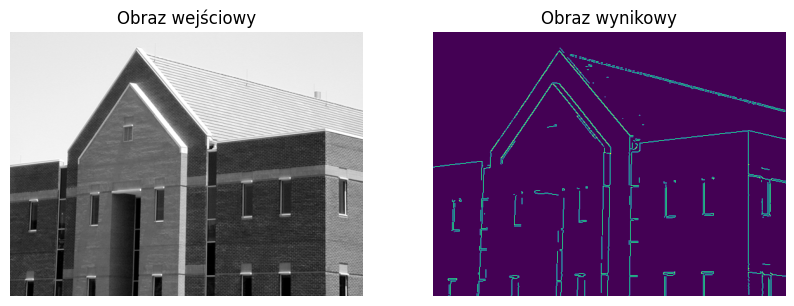

In [3]:
canny_image = cv2.Canny(house,280,320,None,3,1)
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(house,'gray')
plt.title('Obraz wejściowy')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(canny_image)
plt.title('Obraz wynikowy')
plt.axis('off')
plt.show() 

Wykrywanie krawędzi za pomocą metody LoG daje podobny wynik do metody Canny'ego zaimplementowanej w OpenCV, jednak w metodzie LoG krawędzie są grubsze. Metoda Canny'ego zaimplementowana na zajęciach nie wykrywa wszystkich krawędzi.